In [ ]:
собираю данные в датафреймы

In [1]:
import os
import pandas as pd

In [2]:
def find_files(data_folder):
    train_files_paths = []
    test_files_paths = []
    for root, dirs, files in os.walk(data_folder):
        for name in files:
            path = os.path.join(root, name)
            if name.endswith('.txt'):
                if 'test' in path:
                    test_files_paths.append(path)
                elif 'train' in path:
                    train_files_paths.append(path)
                else:
                    continue
    return train_files_paths, test_files_paths

In [3]:
train_files_paths, test_files_paths = find_files('aclImdb')

In [4]:
def construct_df(files_paths):
    columns = ['text', 'target']
    df_name = pd.DataFrame(columns = columns)
    for file in files_paths:
        with open(file, 'r', encoding='utf-8') as f:
            text = f.read()
        sentiment_label = None
        if 'pos' in file:
            sentiment_label = 'POS'
        elif 'neg' in file:
            sentiment_label = 'NEG'
        if sentiment_label is not None:
            df_single_file = pd.DataFrame({'text': [text], 'target': [sentiment_label]})
            df_name = pd.concat([df_name, df_single_file], axis=0)
    return df_name
            

In [5]:
%%time
df_train = construct_df(train_files_paths)
df_test = construct_df(test_files_paths)

CPU times: user 2min 19s, sys: 13.6 s, total: 2min 33s
Wall time: 3min 31s


In [6]:
df_test

,text,target
0,Alan Rickman & Emma Thompson give good perform...,NEG
0,I have seen this movie and I did not care for ...,NEG
0,"In Los Angeles, the alcoholic and lazy Hank Ch...",NEG
0,"This film is bundled along with ""Gli fumavano ...",NEG
0,I only comment on really very good films and o...,NEG
...,...,...
0,"This movie is certainly well-constructed, begi...",POS
0,Nice to see a comedy for grown ups. Masterfull...,POS
0,Jean Renoir's homage to the Paris of the late ...,POS
0,What are the movies? I mean.. what are movies ...,POS


In [ ]:
собираю пайплайн с логистической регрессией используя код из семинара третьей недели

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [8]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range = (2,3))), 
                     ('tfidf', TfidfTransformer()), 
                     ('clf', LogisticRegression())])

In [9]:
%%time
text_clf.fit(df_train.text, df_train.target)  
predicted = text_clf.predict(df_test.text)

CPU times: user 2min, sys: 7.06 s, total: 2min 7s
Wall time: 1min 43s


In [10]:
from sklearn.metrics import *

In [11]:
acc = accuracy_score(df_test.target, predicted)
micro_f1 = f1_score(df_test.target, predicted, average = 'micro')
micro_p = precision_score(df_test.target, predicted, average = 'micro')
micro_r = recall_score(df_test.target, predicted, average = 'micro')
macro_f1 = f1_score(df_test.target, predicted, average = 'macro')
macro_p = precision_score(df_test.target, predicted, average = 'macro')
macro_r = recall_score(df_test.target, predicted, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8641
micro F1=0.8641, micro P=0.8641, micro R=0.8641
macro F1=0.8641, macro P=0.8642, macro R=0.8641



In [ ]:
почему аук на графике и отдельно посчитанный разные? 

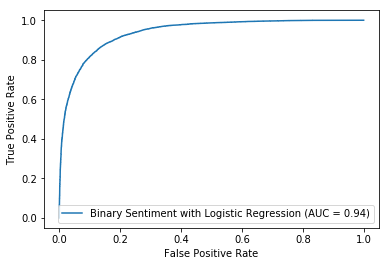

In [41]:
import matplotlib.pyplot as plt
from sklearn import metrics

metrics.plot_roc_curve(text_clf, df_test.text, df_test.target, name='Binary Sentiment with Logistic Regression') 
plt.show()   

In [13]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(['POS', 'NEG'])
y_true = le.transform(df_test.target)
y_predicted = le.transform(predicted)
score = roc_auc_score(y_true, y_predicted)

print(f'ROC AUC {score}')

ROC AUC 0.86408


In [ ]:
оргазиую данные чтобы удобно найти самые негативные и позитивные отзывы

In [14]:
probabilities = text_clf.predict_proba(df_test.text)

In [15]:
df_proba = pd.DataFrame(data=probabilities, columns=["NEG probability", "POS probability"])

In [16]:
df_proba

,NEG probability,POS probability
0,0.551098,0.448902
1,0.506482,0.493518
2,0.512977,0.487023
3,0.750775,0.249225
4,0.790636,0.209364
...,...,...
24995,0.342981,0.657019
24996,0.269783,0.730217
24997,0.218392,0.781608
24998,0.348441,0.651559


In [17]:
neg = df_proba['NEG probability'].tolist()
pos = df_proba['POS probability'].tolist()

In [18]:
df_test['NEG probability'] = neg
df_test['POS probability'] = pos

In [19]:
df_test

,text,target,NEG probability,POS probability
0,Alan Rickman & Emma Thompson give good perform...,NEG,0.551098,0.448902
0,I have seen this movie and I did not care for ...,NEG,0.506482,0.493518
0,"In Los Angeles, the alcoholic and lazy Hank Ch...",NEG,0.512977,0.487023
0,"This film is bundled along with ""Gli fumavano ...",NEG,0.750775,0.249225
0,I only comment on really very good films and o...,NEG,0.790636,0.209364
...,...,...,...,...
0,"This movie is certainly well-constructed, begi...",POS,0.342981,0.657019
0,Nice to see a comedy for grown ups. Masterfull...,POS,0.269783,0.730217
0,Jean Renoir's homage to the Paris of the late ...,POS,0.218392,0.781608
0,What are the movies? I mean.. what are movies ...,POS,0.348441,0.651559


In [20]:
most_negative = df_test.sort_values(by=['NEG probability'], ascending=False)
most_negative.head(15)

,text,target,NEG probability,POS probability
0,I rented this movie today... worst movie EVER....,NEG,0.982302,0.017698
0,...the first? Killjoy 1. But here's the review...,NEG,0.981917,0.018083
0,Definitely the worst movie I have ever seen in...,NEG,0.978170,0.021830
0,Do not waste your money or time. Terrible movi...,NEG,0.978071,0.021929
0,This movie was on the pay channels today and I...,NEG,0.977761,0.022239
0,MAY CONTAIN SPOILERS. This movie was the worst...,NEG,0.977043,0.022957
0,"OK, I would give this a 1, but I'm gonna give ...",NEG,0.976147,0.023853
0,This movie was a complete waste of time. The s...,NEG,0.974242,0.025758
0,This was a very disappointing movie. I would d...,NEG,0.970150,0.029850
0,I couldn't spoil this piece of crap if I wante...,NEG,0.969639,0.030361


In [21]:
most_positive = df_test.sort_values(by=['POS probability'], ascending=False)
most_positive.head(15)

,text,target,NEG probability,POS probability
0,This movie is one of my all-time favorites. I ...,POS,0.037043,0.962957
0,Went to the premiere at the Tribeca Film Festi...,POS,0.037774,0.962226
0,This is one of Bruce's most underrated films i...,POS,0.038139,0.961861
0,One of the best western movies ever made. Unfo...,POS,0.044081,0.955919
0,*May Contain Spoilers*<br /><br />The first ti...,POS,0.053134,0.946866
0,ý thýnk uzak ýs the one of the best films of a...,POS,0.053325,0.946675
0,"""Quai des Orfevres"", directed by the brilliant...",POS,0.054042,0.945958
0,"Wow! Fantastic film in my opinion, i wasn't ex...",POS,0.054586,0.945414
0,I really love action/adventure films and this ...,POS,0.057002,0.942998
0,This is one of Michael Jackson's best music vi...,POS,0.057572,0.942428


In [ ]:
организую данные чтобы удобно посчитать метрики

In [22]:
gold = df_test['target'].tolist()
stats_df = pd.DataFrame()
stats_df['classification output'] = predicted
stats_df['gold standard'] = gold

In [23]:
stats_df

,classification output,gold standard
0,NEG,NEG
1,NEG,NEG
2,NEG,NEG
3,NEG,NEG
4,NEG,NEG
...,...,...
24995,POS,POS
24996,POS,POS
24997,POS,POS
24998,POS,POS


In [24]:
tp = stats_df[(stats_df['classification output'] == 'POS') & (stats_df['gold standard'] == 'POS')].shape[0]
tn = stats_df[(stats_df['classification output'] == 'NEG') & (stats_df['gold standard'] == 'NEG')].shape[0]
fp = stats_df[(stats_df['classification output'] == 'POS') & (stats_df['gold standard'] == 'NEG')].shape[0]
fn = stats_df[(stats_df['classification output'] == 'NEG') & (stats_df['gold standard'] == 'POS')].shape[0]

In [25]:
tp + tn + fp + fn

25000

In [26]:
def stats(tp, tn, fp, fn):
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f2 = 2*(precision * recall)/(precision + recall)
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    return precision, recall, f2, accuracy

In [27]:
def precision(tp, fp):
    precision = tp/(tp + fp)
    return precision

In [28]:
def recall(tp, fn):
    recall = tp/(tp + fn)
    return recall

In [29]:
def f2(tp, fp, fn):
    f2 = 2*(tp/(tp + fp) * tp/(tp + fn))/(tp/(tp + fp) + tp/(tp + fn))
    return f2

In [30]:
def accuracy(tp, tn, fp, fn):
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    return accuracy

In [31]:
pr = precision(tp, fp)
re = recall(tp, fn)
f2 = f2(tp, fp, fn)
ac = accuracy(tp, tn, fp, fn)

In [32]:
pr

0.8589682915286323

In [33]:
re

0.8712

In [34]:
f2

0.8650409087298435

In [35]:
ac

0.86408

In [36]:
precision, recall, f2, accuracy = stats(tp, tn, fp, fn)

In [37]:
precision

0.8589682915286323

In [38]:
recall

0.8712

In [39]:
f2

0.8650409087298435

In [40]:
accuracy

0.86408

# Я не понимаю, почему числа отличаются, ведь они должны быть одинкавыми - написала два способа вычисления для f2 и ничего не изменилось. Не понимаю:(